In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import torch
import esm
from torch.utils.data import DataLoader, Dataset
from torch import cuda
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def clean_sequence(sequence):
    parts = sequence.split(">")
    cleaned_parts = [part.split(" ", 1)[-1].strip() for part in parts if part.strip()]
    cleaned_sequence = " ".join(cleaned_parts)
    cleaned_sequence = re.sub(r"\(.*?\)", "", cleaned_sequence)
    return cleaned_sequence.strip()

In [3]:
def prepare_data(file_path):
    data = pd.read_csv(file_path)
    filtered_data = data[["interactor_sequence", "aggregation_speed"]].copy()
    filtered_data = filtered_data[filtered_data["aggregation_speed"] != "No information"]
    
    label_mapping = {
        "Faster aggregation": 2,
        "Slower aggregation": 1,
        "No effect": 0,
        "No aggregation": 0
    }
    
    filtered_data["label"] = filtered_data["aggregation_speed"].map(label_mapping)
    filtered_data = filtered_data.dropna(subset=["label"])
    filtered_data["interactor_sequence"] = filtered_data["interactor_sequence"].apply(clean_sequence)
    
    filtered_data["seq_length"] = filtered_data["interactor_sequence"].str.len()
    filtered_data = filtered_data[filtered_data["seq_length"] <= 1024]
    
    return train_test_split(filtered_data, test_size=0.2, random_state=42, stratify=filtered_data["label"])

In [4]:
class ProteinDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = [int(label) for label in labels] 
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [5]:
class ProteinClassifier(torch.nn.Module):
    def __init__(self, base_model, num_classes=3):
        super().__init__()
        self.base_model = base_model
        self.dropout = torch.nn.Dropout(0.5)
        self.classification_head = torch.nn.Sequential(
            torch.nn.Linear(base_model.embed_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_classes),
        )
        
    def forward(self, tokens):
        outputs = self.base_model(tokens, repr_layers=[6])
        embeddings = outputs["representations"][6][:, 0, :]  # CLS token
        embeddings = self.dropout(embeddings)
        return self.classification_head(embeddings)

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.stop = True

In [7]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    total_loss = 0
    predictions_list = []
    labels_list = []
    
    for labels, sequences, tokens in dataloader:
        tokens = tokens.to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        logits = model(tokens)
        loss = criterion(logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5) 
        optimizer.step()
        
        total_loss += loss.item()
        predictions_list.extend(logits.argmax(dim=1).cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
    
    if scheduler is not None:
        scheduler.step(total_loss / len(dataloader))
        
    return total_loss / len(dataloader), predictions_list, labels_list

In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions_list = []
    labels_list = []
    
    with torch.no_grad():
        for labels, sequences, tokens in dataloader:
            tokens = tokens.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            
            logits = model(tokens)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            predictions_list.extend(logits.argmax(dim=1).cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
    
    return (
        total_loss / len(dataloader),
        predictions_list,
        labels_list
    )

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

train_data, test_data = prepare_data('./data/AmyloGraph.csv')

base_model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

In [10]:
train_dataset = ProteinDataset(train_data["interactor_sequence"].tolist(), train_data["label"].tolist())
test_dataset = ProteinDataset(test_data["interactor_sequence"].tolist(), test_data["label"].tolist())

In [11]:
train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        collate_fn=lambda batch: batch_converter([(int(label), seq) for seq, label in batch])
    )
    
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda batch: batch_converter([(int(label), seq) for seq, label in batch])
)

In [12]:
model = ProteinClassifier(base_model).to(device)

In [13]:
trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
print(f"Trainable Parameters ({len(trainable_params)})")

Trainable Parameters (110)


In [14]:
optimizer = torch.optim.AdamW([
    {'params': model.base_model.parameters(), 'lr': 1e-5},
    {'params': model.classification_head.parameters(), 'lr': 1e-4}], weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=50,
    eta_min=1e-6
)

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 2.0]).to(device))

In [15]:
early_stopping = EarlyStopping(patience=5, min_delta=1e-4, verbose=True)

num_epochs = 50
best_val_loss = float('inf')
best_model_state = None
print_interval = 5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, train_preds, train_labels = train_one_epoch(
        model, train_loader, optimizer, criterion, device, scheduler
    )
    val_loss, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    early_stopping(val_loss)    
    if early_stopping.stop:
        print(f"Early stopping triggered at epoch {epoch + 1}.")
        break
        
print("\nFinal Training Results:")
print(f"Train Loss: {train_losses[-1]:.4f}")
print(f"Val Loss: {val_losses[-1]:.4f}")

print("\nValidation Classification Report:")
print(classification_report(val_labels, val_preds))

torch.save(model.state_dict(), "work_dir/esm_finetuned_model.pt")

Epoch 5/50
Train Loss: 0.8910
Val Loss: 0.8741

Epoch 10/50
Train Loss: 0.7972
Val Loss: 0.8250

EarlyStopping counter: 1/5
EarlyStopping counter: 2/5
EarlyStopping counter: 3/5
Epoch 15/50
Train Loss: 0.7769
Val Loss: 0.8384

EarlyStopping counter: 1/5
EarlyStopping counter: 2/5
EarlyStopping counter: 3/5
EarlyStopping counter: 4/5
EarlyStopping counter: 5/5
Early stopping triggered at epoch 19.

Final Training Results:
Train Loss: 0.7372
Val Loss: 0.8225

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.17      0.29        52
           1       0.46      0.61      0.52        38
           2       0.63      0.84      0.72        86

    accuracy                           0.59       176
   macro avg       0.63      0.54      0.51       176
weighted avg       0.65      0.59      0.55       176



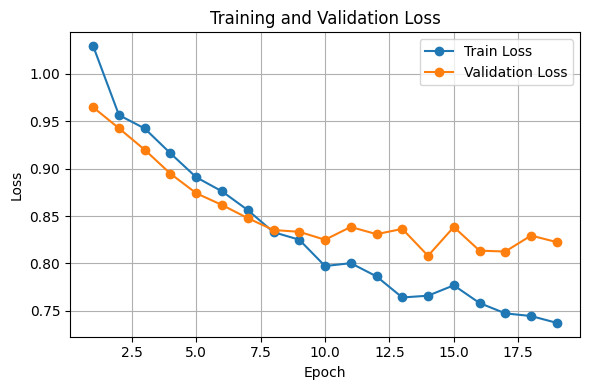

In [18]:
def plot_loss(num_epochs, train_losses, val_losses):
    actual_epochs = len(train_losses) 
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, actual_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, actual_epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss(len(train_losses), train_losses, val_losses)

In [19]:
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    final_loss, final_preds, final_labels = evaluate(model, test_loader, criterion, device)
    print("\nFinal Model Performance:")
    print(f"Test Loss: {final_loss:.4f}")
    print("\nTest Classification Report:")
    print(classification_report(final_labels, final_preds))
    print("\nConfusion Matrix:")
    print(confusion_matrix(final_labels, final_preds))

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, 'protein_classifier_best.pth')


Final Model Performance:
Test Loss: 0.8225

Test Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.17      0.29        52
           1       0.46      0.61      0.52        38
           2       0.63      0.84      0.72        86

    accuracy                           0.59       176
   macro avg       0.63      0.54      0.51       176
weighted avg       0.65      0.59      0.55       176


Confusion Matrix:
[[ 9 15 28]
 [ 0 23 15]
 [ 2 12 72]]


In [20]:
model = ProteinClassifier(base_model)
model.load_state_dict(torch.load("work_dir/esm_finetuned_model.pt"))
model.eval()
model.to(device)

ProteinClassifier(
  (base_model): ESM2(
    (embed_tokens): Embedding(33, 320, padding_idx=1)
    (layers): ModuleList(
      (0-5): 6 x TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=320, out_features=320, bias=True)
          (v_proj): Linear(in_features=320, out_features=320, bias=True)
          (q_proj): Linear(in_features=320, out_features=320, bias=True)
          (out_proj): Linear(in_features=320, out_features=320, bias=True)
          (rot_emb): RotaryEmbedding()
        )
        (self_attn_layer_norm): ESM1bLayerNorm(torch.Size([320]), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=320, out_features=1280, bias=True)
        (fc2): Linear(in_features=1280, out_features=320, bias=True)
        (final_layer_norm): ESM1bLayerNorm(torch.Size([320]), eps=1e-05, elementwise_affine=True)
      )
    )
    (contact_head): ContactPredictionHead(
      (regression): Linear(in_features=120, out_features=1, bias=

In [21]:
import torch.nn.functional as F

def predict_sequence(model, sequence, batch_converter, device):
    data = [("sequence", sequence)]
    _, _, tokens = batch_converter(data)
    tokens = tokens.to(device)
    
    with torch.no_grad():
        logits = model(tokens)
        probabilities = F.softmax(logits, dim=1).cpu().numpy()[0]
        predicted_label = probabilities.argmax()
    
    return predicted_label, probabilities


In [22]:
# Sample sequence
sequence = "ACDEFGHIKLMNPQRSTVWY"

# batch_converter
batch_converter = alphabet.get_batch_converter()

predicted_label, probabilities = predict_sequence(model, sequence, batch_converter, device)

print(f"Sequence: {sequence}")
print(f"Predicted Label: {predicted_label}")
print(f"Probabilities: {probabilities}")

Sequence: ACDEFGHIKLMNPQRSTVWY
Predicted Label: 2
Probabilities: [0.29917324 0.16167556 0.53915125]
